<a href="https://colab.research.google.com/github/nickwinters1/DS-Unit-4-Sprint-2-Neural-Networks/blob/master/LS_DS_Unit_4_Sprint_Challenge_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 2*

# Sprint Challenge - Neural Network Foundations

Table of Problems

1. [Defining Neural Networks](#Q1)
2. [Perceptron on XOR Gates](#Q2)
3. [Multilayer Perceptron](#Q3)
4. [Keras MMP](#Q4)

<a id="Q1"></a>
## 1. Define the following terms:

- **Neuron:** neurons receive inputs and pass on their signal to the next layer of nodes if a certain threshold is reached
- **Input Layer:** The Input Layer is what receives input from our dataset. Sometimes it is called the visible layer because it's the only part that is exposed to our data and that our data interacts with directly.
- **Hidden Layer:** Layers after the input layer are called Hidden Layers. This is because they cannot be accessed except through the input layer. They're inside of the network and they perform their functions, but we don't directly interact with them. 
- **Output Layer:** The final layer is called the Output Layer. The purpose of the output layer is to output a vector of values that is in a format that is suitable for the type of problem that we're trying to address
- **Activation:** The activation function decides whether a cell "fires" or not. Sometimes it is said that the cell is "activated" or not. In Artificial Neural Networks activation functions decide how much signal to pass onto the next layer. 
- **Backpropagation:**  Back-propagation is the essence of neural net training. It is the practice of fine-tuning the weights of a neural net based on the error rate obtained in the previous epoch. Proper tuning of the weights ensures lower error rates, making the model reliable by increasing its generalization.


## 2. Perceptron on XOR Gates <a id="Q3=2"></a>

Create a perceptron class that can model the behavior of an AND gate. You can use the following table as your training data:

|x1	|x2|x3|	y|
|---|---|---|---|
1|	1|	1|	1|
1|	0|	1|	0|
0|	1|	1|	0|
0|	0|	1|	0|

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD, Adam, Nadam
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [0]:
class PerceptronClassifier():
    """
    Basic perceptron class for binary classification
    """
    def __init__(self, learning_rate=0.1, n_iter=100, tolerance=0.000001):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.tolerance = tolerance
    
    def fit(self, X, y):
        """
        Fit perceptron to a set of training data using gradient descent
        """
        # initialize weights and cost list
        self.weights_ = np.random.uniform(-0.01, 0.01, X.shape[1] + 1)
        self.costs_ = []
        # iterate until fit is adequate
        for i in range(self.n_iter):
            preds = self.predict_proba(X)
            errors = preds - y
            cost = np.sum(errors ** 2)
            self.costs_.append(cost)
            gradient = np.dot(X.T, errors)
            self.weights_[1:] -= self.learning_rate * gradient
            self.weights_[0] -= np.mean(errors)
            
            # break the loop if we are close enough
            if cost < self.tolerance:
                break
            
        return self
    
    def predict_proba(self, X):
        """
        Computes sigmoid output value given X
        """
        return 1. / (1. + np.exp(-(np.dot(X, self.weights_[1:]) + self.weights_[0])))
    
    def predict(self, X):
        """
        Predicts the binary class of X values
        """
        return np.where(self.predict_proba(X)>=0.5, 1, 0)
    
    def show_loss(self):
        """
        Shows loss along epochs
        """
        try:
            iters = range(len(self.costs_))
            fig, ax = plt.subplots()
            ax.plot(iters, self.costs_)
            ax.set_xlabel('Number of Iterations')
            ax.set_ylabel('Training Loss (SSE)')
            ax.set_title('Training Loss')
            plt.show()
        except:
            print ('Please train me first :)')

In [3]:
X = np.array([[1,1,1],
            [1,0,1],
            [0,1,1],
            [0,0,1]])
y = np.array([1,0,0,0])

ppn = PerceptronClassifier(learning_rate = 1.0, n_iter=100)
ppn.fit(X, y)
ppn.predict(X)

array([1, 0, 0, 0])

## 3. Multilayer Perceptron <a id="Q3"></a>

Implement a Neural Network Multilayer Perceptron class that uses backpropagation to update the network's weights.
Your network must have one hidden layer.
You do not have to update weights via gradient descent. You can use something like the derivative of the sigmoid function to update weights.
Train your model on the Heart Disease dataset from UCI:



In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [0]:
import sys
import numpy as np

class NeuralNetMLP(object):
    """
    Feed forward nueral network / multi-layer perceptron classifier
    
    Parameters
    ----------
    n_hidden : int (default: 30)
        Number of hidden units
    l2 : float (default 0.)
        Lambda value for l2 normalization
    epochs : int (default: 100)
        Number of training epochs
    eta : float (default = 0.001)
        Learning rate
    shuffle : bool (default: True)
        Shuffles the training data every epoch if True
    minibatch_size : int (default : 1)
        Number of training samples per minibatch
    seed : int (default: None)
        Random seed for initalizing weights and shuffling
    
    Attributes
    ----------
    eval_ : dict
        Dictionary collecting the cost, training accuracy,
        and validation accuracy for each epoch during training
    
    """
    
    def __init__(self, n_hidden=30, l2=0.,
                epochs=100, eta=0.0001,
                shuffle=True, minibatch_size=1, seed=None):
        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size
        
    def _onehot(self, y, n_classes):
        """
        Encode labels into one hot representation
        
        Parameters
        ----------
        y : array, shape = [n_samples]
            Target values
        
        Returns
        -------
        onehot : array, shape = (n_samples, n_labels)
        """
        
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T
          
    def _sigmoid(self, z):
        """
        Compute logistic function (sigmoid)
        """
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def _forward(self, X):
        """
        Compute forward propogation step
        """
        # step 1: net input of hidden layer
        z_h = np.dot(X, self.w_h) + self.b_h
        
        # step 2: activation of hidden layer
        a_h = self._sigmoid(z_h)
        
        # step 3: net input of output layer
        z_out = np.dot(a_h, self.w_out) + self.b_out
        
        # step 4: activation layer output
        a_out = self._sigmoid(z_out)
        
        return z_h, a_h, z_out, a_out
    
    def _compute_cost(self, y_enc, output):
        """
        Compute cost function
        
        Parameters
        ----------
        y_enc : array, shape = (n_samples, n_labels)
            one-hot encoded class labels
        output : array, shape = [n_samples, n_output_units]
            Activation of the output layer (forward propoagation)
        Returns
        -------
        cost : float
            Regularized cost
        """
        e = 0.000000001
        L2_term = (self.l2 *
                  (np.sum(self.w_h ** 2.) + 
                  np.sum(self.w_out ** 2.)))
        term1 = -y_enc * (np.log(output + e))
        term2 = (1. - y_enc) * np.log(1. - output + e)
        cost = np.sum(term1 - term2) + L2_term
        return cost
    
    def predict(self, X):
        """
        Predict class labels
        
        Paramters
        ---------
        X : array, shape = [n_samples, n_features]
            Input layer with original features
        
        Returns
        -------
        y_pred : array, shape = [n_samples]
            Predicted class labels
        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred
          
    def fit(self, X_train, y_train, X_valid, y_valid):
        """
        Learn weights from training data
        
        Parameters
        ----------
        X_train : array, shape = [n_samples, n_features]
            Input layer with original features
        y_train : array, shape = [n_samples]
            Target class labels
        X_test : array, shape = [n_samples, n_features]
            Sample features for validation during training
        y_test : array, shape = [n_samples]
            Samples test class labels for validation during training
            
        Returns
        -------
        self
        """
        n_output = np.unique(y_train).shape[0]
        n_features = X_train.shape[1]
        
        #######################
        # Weight Initialization
        #######################
        
        # weights for input -> hidden
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0,
                                     scale=0.1,
                                     size=(n_features,
                                          self.n_hidden))
        
        # weights for hidden -> output
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0,
                                       scale=0.1,
                                       size=(self.n_hidden,
                                       n_output))
        
        epoch_strlen = len(str(self.epochs)) # for progr. format
        self.eval_ = {'train_cost' : [],
                      'val_cost' : [],
                     'train_acc' : [],
                     'valid_acc' : []}
        
        y_train_enc = self._onehot(y_train, n_output)
        y_valid_enc = self._onehot(y_valid, n_output)
        
        # iterate over training epochs
        for i in range(self.epochs):
            
            # iterate over mini batches
            indices = np.arange(X_train.shape[0])
            
            if self.shuffle:
                self.random.shuffle(indices)
            
            for start_idx in range(0, indices.shape[0] - self.minibatch_size + 1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]
                                
                # forward propagation
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])
                
                #################
                # Backpropagation
                #################
                
                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]
                
                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)
                
                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) * sigmoid_derivative_h)
                
                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)
                
                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)
                
                # Regularization and weight updates
                delta_w_h = (grad_w_h + self.l2 * self.w_h)
                delta_b_h = grad_b_h # bias is not regularized
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h
                
                delta_w_out = grad_w_out + self.l2 * self.w_out
                delta_b_out = grad_b_out # bias is not regularized
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out
                
            ############
            # Evaluation
            ############

            # evaluation after each epoch during training
            z_h, a_h, z_out, a_out = self._forward(X_train)
            z_h_val, a_h_val, z_out_val, a_out_val = self._forward(X_valid)
            
            cost = self._compute_cost(y_enc=y_train_enc, output=a_out) / a_out.shape[0]
            cost_val = self._compute_cost(y_enc=y_valid_enc, output=a_out_val) / a_out_val.shape[0]
            
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)
            
            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) / X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) / X_valid.shape[0])
            
            sys.stderr.write('\r%0*d/%d | Cost: %.2f | Train/Valid Acc: %.2f%%/%.2f%%'
                            % (epoch_strlen, i+1, self.epochs, cost, train_acc*100, valid_acc*100))
            sys.stderr.flush()
            
            self.eval_['train_cost'].append(cost)
            self.eval_['val_cost'].append(cost_val)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
            
        return self
    
    def plot_training(self):
        """
        Plots training loss and accuracy
        """
        fig, ax = plt.subplots(ncols=2, figsize=(12,7))
        
        # plotting loss
        ax[0].plot(range(self.epochs), self.eval_['train_cost'], label='Train')
        ax[0].plot(range(self.epochs), self.eval_['val_cost'], label='Validation')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Cost')
        ax[0].set_title('Training Cost')
        ax[0].legend(loc='best')
        
        ax[1].plot(range(self.epochs), self.eval_['train_acc'], label='Train')
        ax[1].plot(range(self.epochs), self.eval_['valid_acc'], label='Validation')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Cost')
        ax[1].set_title('Training Accuracy')
        ax[0].legend(loc='best')
        
        plt.show()

In [0]:
X = data.drop(columns='target')
y = data.target

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y,
                                                 stratify=y)
# scale data
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_val = scale.transform(X_val)

In [7]:
mlp = NeuralNetMLP(n_hidden=30,
                  eta=0.001)
mlp.fit(X_train=X_train, 
        y_train=y_train.values, 
        X_valid=X_val, 
        y_valid=y_val.values);

100/100 | Cost: 0.78 | Train/Valid Acc: 85.02%/88.16%

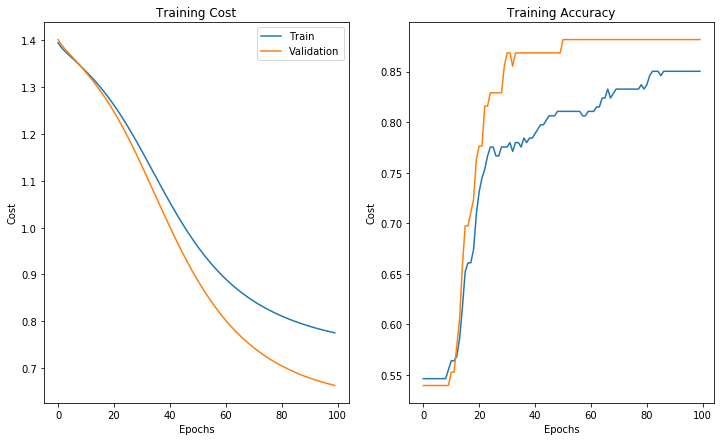

In [8]:
mlp.plot_training()

## 4. Keras MMP <a id="Q4"></a>

Implement a Multilayer Perceptron architecture of your choosing using the Keras library. Train your model and report its baseline accuracy. Then hyperparameter tune at least two parameters and report your model's accuracy.
Use the Heart Disease Dataset (binary classification)
Use an appropriate loss function for a binary classification task
Use an appropriate activation function on the final layer of your network.
Train your model using verbose output for ease of grading.
Use GridSearchCV to hyperparameter tune your model. (for at least two hyperparameters)
When hyperparameter tuning, show you work by adding code cells for each new experiment.
Report the accuracy for each combination of hyperparameters as you test them so that we can easily see which resulted in the highest accuracy.
You must hyperparameter tune at least 5 parameters in order to get a 3 on this section.

In [0]:
def create_model(dense_layers=2,
                 dense_nodes=5,
                 dropout=False,
                 dropout_pct=0.0,
                 activation='sigmoid',
                 weight_initializer='glorot_uniform',
                 optimizer=SGD,
                 lr=0.0001,
                 input_shape=(X_train.shape[1],)):
    
    model = Sequential()
    
    # add input layer
    model.add(Dense(dense_nodes, 
                    input_shape=input_shape,
                    kernel_initializer=weight_initializer,
                    activation=activation))
    
    # add dense layers and drop out
    for _ in range(dense_layers):
        # dense
        model.add(Dense(dense_nodes,
                        kernel_initializer=weight_initializer,
                        activation=activation))
        # dropout
        if dropout:
            model.add(Dropout(rate=dropout_pct))

    # add final activation layer
    model.add(Dense(1, activation='sigmoid'))
    # optimizer
    optimizer=optimizer(lr=lr)
    # compile model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
              
    return model

In [10]:
epochs = 20
batch_size = 20

# create model
model = KerasClassifier(build_fn=create_model, 
                               epochs=epochs,
                               batch_size=batch_size,
                               verbose=0)

# define the grid search parameters
param_grid = {}

# Create Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    cv=5,
                    n_jobs=1)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

W0719 17:00:04.877549 140022329350016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 17:00:04.919279 140022329350016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 17:00:04.926271 140022329350016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0719 17:00:05.013015 140022329350016 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0719 17:00:05.023814 140022329350016 deprecation_wrappe

Best: 0.4581497765847765 using {}
Means: 0.4581497765847765, Stdev: 0.07513302108562053 with: {}


In [11]:
# define the grid search parameters
param_grid = {'batch_size': [10, 20, 40, 60, 80],
              'epochs': [30, 60, 90]}

# create model
model = KerasClassifier(build_fn=create_model, 
                               epochs=epochs,
                               batch_size=batch_size,
                               verbose=0)

# Create Grid Search
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    cv=5,
                    n_jobs=1)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.5462555178986772 using {'batch_size': 80, 'epochs': 60}
Means: 0.5462555144851954, Stdev: 0.07250406530604263 with: {'batch_size': 10, 'epochs': 30}
Means: 0.5462555144851954, Stdev: 0.07250406530604263 with: {'batch_size': 10, 'epochs': 60}
Means: 0.48458150462432054, Stdev: 0.08460899147660379 with: {'batch_size': 10, 'epochs': 90}
Means: 0.4537444929982072, Stdev: 0.07250406738596081 with: {'batch_size': 20, 'epochs': 30}
Means: 0.5110132158590308, Stdev: 0.056245179467437435 with: {'batch_size': 20, 'epochs': 60}
Means: 0.5462555005030485, Stdev: 0.07250406719969738 with: {'batch_size': 20, 'epochs': 90}
Means: 0.5462555083803143, Stdev: 0.07250406544585167 with: {'batch_size': 40, 'epochs': 30}
Means: 0.4845815006856876, Stdev: 0.08460899015167125 with: {'batch_size': 40, 'epochs': 60}
Means: 0.5154184978045031, Stdev: 0.08460898633204307 with: {'batch_size': 40, 'epochs': 90}
Means: 0.4581497844620423, Stdev: 0.07513302803961282 with: {'batch_size': 60, 'epochs': 30}
Mean

In [12]:
# create model
model = KerasClassifier(build_fn=create_model, 
                               epochs=30,
                               batch_size=10,
                               verbose=0)

# define the grid search parameters
param_grid = {'optimizer': [SGD, Adam, Nadam],
              'lr': [.01, .001, .0001, .00001]}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.806167389852885 using {'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>}
Means: 0.5462555112030012, Stdev: 0.061423006305868166 with: {'lr': 0.01, 'optimizer': <class 'keras.optimizers.SGD'>}
Means: 0.806167389852885, Stdev: 0.04336120800360705 with: {'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>}
Means: 0.7797356780930238, Stdev: 0.054054760898376186 with: {'lr': 0.01, 'optimizer': <class 'keras.optimizers.Nadam'>}
Means: 0.42731278274815515, Stdev: 0.025078386373467973 with: {'lr': 0.001, 'optimizer': <class 'keras.optimizers.SGD'>}
Means: 0.6123348034032116, Stdev: 0.1404456012497063 with: {'lr': 0.001, 'optimizer': <class 'keras.optimizers.Adam'>}
Means: 0.6563876715656944, Stdev: 0.13901254631686935 with: {'lr': 0.001, 'optimizer': <class 'keras.optimizers.Nadam'>}
Means: 0.5726872278861538, Stdev: 0.02507838355185056 with: {'lr': 0.0001, 'optimizer': <class 'keras.optimizers.SGD'>}
Means: 0.4801762157205968, Stdev: 0.07429249629909093 with: {'lr': 0.000

In [13]:
# create model
model = KerasClassifier(build_fn=create_model, 
                               epochs=30,
                               batch_size=10,
                               verbose=0)

# define the grid search parameters
param_grid = {'activation': ['sigmoid', 'tanh', 'relu'],
              'optimizer': [Adam],
              'lr': [.01]}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.8061673945792446 using {'activation': 'sigmoid', 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>}
Means: 0.8061673945792446, Stdev: 0.027263929006820124 with: {'activation': 'sigmoid', 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>}
Means: 0.7709251159088202, Stdev: 0.03772249056440599 with: {'activation': 'tanh', 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>}
Means: 0.7533039642325582, Stdev: 0.033239984292422864 with: {'activation': 'relu', 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>}


In [14]:
# create model
model = KerasClassifier(build_fn=create_model, 
                               epochs=30,
                               batch_size=10,
                               verbose=0)

# define the grid search parameters
param_grid = {'weight_initializer': ['glorot_uniform', 
                                     'random_uniform', 
                                     'random_normal'],
              'activation' : ['relu'],
             'optimizer' : [Adam],
             'lr' : [0.01]}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.7797356833445344 using {'activation': 'relu', 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>, 'weight_initializer': 'glorot_uniform'}
Means: 0.7797356833445344, Stdev: 0.04334236567606776 with: {'activation': 'relu', 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>, 'weight_initializer': 'glorot_uniform'}
Means: 0.6916299577851652, Stdev: 0.08086188901394809 with: {'activation': 'relu', 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>, 'weight_initializer': 'random_uniform'}
Means: 0.5462555112030012, Stdev: 0.061423006305868166 with: {'activation': 'relu', 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>, 'weight_initializer': 'random_normal'}


In [15]:
model = KerasClassifier(build_fn=create_model, 
                               epochs=30,
                               batch_size=10,
                               verbose=0)

# define the grid search parameters
param_grid = {'dropout' : [True, False],
             'dropout_pct' : [0.1, 0.2, 0.3],
              'weight_initializer': ['random_uniform'],
              'activation' : ['relu'],
             'optimizer' : [Adam],
             'lr' : [0.01]}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
W0719 17:45:11.134628 140022329350016 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Best: 0.8017621129619917 using {'activation': 'relu', 'dropout': True, 'dropout_pct': 0.3, 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>, 'weight_initializer': 'random_uniform'}
Means: 0.7356828189237528, Stdev: 0.10458801355945829 with: {'activation': 'relu', 'dropout': True, 'dropout_pct': 0.1, 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>, 'weight_initializer': 'random_uniform'}
Means: 0.7885462547188814, Stdev: 0.04750726381637613 with: {'activation': 'relu', 'dropout': True, 'dropout_pct': 0.2, 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>, 'weight_initializer': 'random_uniform'}
Means: 0.8017621129619917, Stdev: 0.061078373459293886 with: {'activation': 'relu', 'dropout': True, 'dropout_pct': 0.3, 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>, 'weight_initializer': 'random_uniform'}
Means: 0.7753303906991094, Stdev: 0.02899168905333891 with: {'activation': 'relu', 'dropout': False, 'dropout_pct': 0.1, 'lr': 0.01, 'optimizer': <class 'ke

In [16]:
model = KerasClassifier(build_fn=create_model, 
                               epochs=30,
                               batch_size=10,
                               verbose=0)

# define the grid search parameters
param_grid = {'dense_layers' : [1,2],
              'dense_nodes' : [5, 10, 15, 20, 25],
              'weight_initializer': ['random_uniform'],
              'activation' : ['relu'],
             'optimizer' : [Adam],
             'lr' : [0.01]}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best: 0.7973568203165667 using {'activation': 'relu', 'dense_layers': 2, 'dense_nodes': 10, 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>, 'weight_initializer': 'random_uniform'}
Means: 0.7797356786181748, Stdev: 0.05405476520288825 with: {'activation': 'relu', 'dense_layers': 1, 'dense_nodes': 5, 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>, 'weight_initializer': 'random_uniform'}
Means: 0.7488986768386438, Stdev: 0.07041868238947577 with: {'activation': 'relu', 'dense_layers': 1, 'dense_nodes': 10, 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>, 'weight_initializer': 'random_uniform'}
Means: 0.7753303933248646, Stdev: 0.05531874173361575 with: {'activation': 'relu', 'dense_layers': 1, 'dense_nodes': 15, 'lr': 0.01, 'optimizer': <class 'keras.optimizers.Adam'>, 'weight_initializer': 'random_uniform'}
Means: 0.7400881059894477, Stdev: 0.054033032819223316 with: {'activation': 'relu', 'dense_layers': 1, 'dense_nodes': 20, 'lr': 0.01, 'optimizer': <class 